<a id = "ref00"></a>

<center><h3> BSc Hons Finance & Investment Management </h3></center>

<a><img src="UUBS.png" width="180" height="180" border="10" /></a>

<hr>

<center>
<h2>FIN303: Financial Modelling</h2>
<h2>Coursework 2: Individual Report (50%)</h2>
<h1><span style="color:blue">Signal-based Trading on SPY[ETF]</h1>
<h2><span style="color:blue">Report Notebook 01</h2>
<h3>11.59pm Friday December 27 2024</h3></span></centre>
<br>
<br>

###  <span style="color:blue">Your Details</span>

In [1]:
# Shift+Enter on this cell to record your name and Student ID

input('Please input your full name and Student ID:') 

Please input your full name and Student ID:Felix B00918654


'Felix B00918654'

### Multiple linear regression

In this notebook you should build and test a multiple linear regression prediction model for the next-day opening price of the SPY[ETF] based on historical data from a global range of stock markets. **You must use the precise combination of indices and data allocated to you.**

This is the first and most critical step in the process of building a signal-based trading model for the SPY[ETF], which will be the subject of Report Notebook 02.

In [2]:
# import any and all packages you need in this cell 
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# leave this cell unchanged but be sure to Run it.
import warnings
warnings.filterwarnings("ignore")

### Step 0: Importing data into seperate data frames

In [4]:
# Import ONLY those data relating to the combination of indices 
# allocated to you. Consult the file Report Student-Data combinations.pdf
# in this folder to identify your specifc dataset allocation.
# All Ordinary(Australia)
aord = pd.read_csv('data/indexdata/ALLOrdinary.csv').set_index('Date')
# Hang Seng(Hong Kong)
hsi = pd.read_csv('data/indexdata/HSI.csv').set_index('Date')
# CAC40(France)
cac40 = pd.read_csv('data/indexdata/CAC40.csv').set_index('Date')
# Standard and Poor's(US)
sp500 = pd.read_csv('data/indexdata/SP500.csv').set_index('Date')
# Dow Jones(US)
dji = pd.read_csv('data/indexdata/DJI.csv').set_index('Date')
# SPY[ETF](US)
spy = pd.read_csv('data/indexdata/SPY.csv').set_index('Date')

In [5]:
# run this cell as a check-thus-far
spy.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-12-31,125.529999,125.870003,125.330002,125.750000,102.055618,91218900
2011-01-03,126.709999,127.599998,125.699997,127.050003,103.110634,138725200
2011-01-04,127.330002,127.370003,126.190002,126.980003,103.053825,137409700
2011-01-05,126.580002,127.720001,126.459999,127.639999,103.589462,133975300
2011-01-06,127.690002,127.830002,127.010002,127.389999,103.386566,122519000


### Step 1: Data Munging

In [6]:
# due to time-zone differences, you should extract appropriate stock
# market data for analysis. 

# Indexpanel will be the DataFrame for your trading model.
Indexpanel = pd.DataFrame(index=spy.index)
# SPY[ETF]
Indexpanel['spy']=spy['Open'].shift(-1)-spy['Open']
Indexpanel['spy_lag1']=Indexpanel['spy'].shift(1)
# US Market
Indexpanel['sp500']=sp500["Open"]-sp500['Open'].shift(1)
Indexpanel['dji']=dji['Open']-dji['Open'].shift(1)
# European Markets
Indexpanel['cac40']=cac40['Open']-cac40['Open'].shift(1)
# Asian/Australian Markets
Indexpanel['aord']=aord['Close']-aord['Open']
Indexpanel['hsi']=hsi['Close']-hsi['Open']
# used for paper trading in next video
Indexpanel['Price']=spy['Open']


In [7]:
# run this cell as a check-thus-far
Indexpanel.head()

,spy,spy_lag1,sp500,dji,cac40,aord,hsi,Price
Date,,,,,,,,
2010-12-31,1.180000,NaN,NaN,NaN,NaN,NaN,NaN,125.529999
2011-01-03,0.620003,1.180000,0.859985,8.099610,NaN,NaN,300.410156,126.709999
2011-01-04,-0.750000,0.620003,15.329956,93.470703,60.620117,-9.000000,191.169922,127.330002
2011-01-05,1.110000,-0.750000,-4.169922,17.709961,-3.780029,-25.200196,107.640625,126.580002
2011-01-06,-0.130004,1.110000,7.510010,28.319336,6.870117,7.899903,-74.919922,127.690002


In [8]:
# you should check to see if you have NaN values in Indexpanel
Indexpanel.isnull().sum()

spy           1
spy_lag1      1
sp500         1
dji           1
cac40        33
aord         57
hsi         127
Price         0
dtype: int64

In [9]:
# use the DataFrame method .fillna() to forward fill 
# any Nan values. Drop any remaining Nan values
Indexpanel = Indexpanel.fillna(method='ffill')
Indexpanel = Indexpanel.dropna()


In [10]:
# check to see if you have any Nan values in Indexpanel now...
Indexpanel.isnull().sum()


spy         0
spy_lag1    0
sp500       0
dji         0
cac40       0
aord        0
hsi         0
Price       0
dtype: int64

In [11]:
# save your Indexpanel data frame object to CSV for later use
Indexpanel.to_csv('data/indexdata/Indexpanel.csv')



In [12]:
# run this cell as a check-thus-far
print(Indexpanel.shape)

(2695, 8)


### Step 2: Splitting the data 

In [13]:
# split the data into non-overlapping training and test sets
Train = Indexpanel.iloc[-2000:-1000, :]
Test = Indexpanel.iloc[-1000:, :]
print(Train.shape, Test.shape)


(1000, 8) (1000, 8)


### Step 3: Exploring the training data set

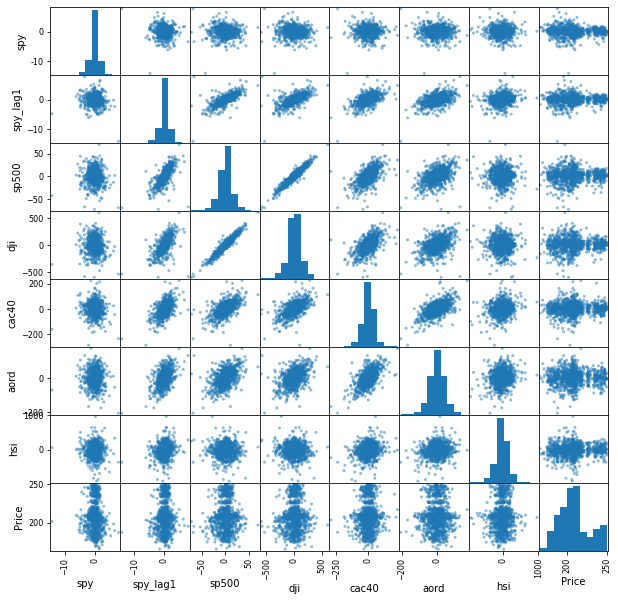

In [14]:
# generate a scatter-matrix across your stock markets 
# (and the price of SPY) to observe the association
from pandas.plotting import scatter_matrix
sm = scatter_matrix(Train,figsize=(10, 10))



### Step 4: Check the correlation of each index with spy

In [15]:
# find the indices with the strongest association
corr_array = Train.iloc[:, :-1].corr()['spy']
print(corr_array)


spy         1.000000
spy_lag1   -0.080055
sp500      -0.029144
dji        -0.040200
cac40      -0.046365
aord       -0.007880
hsi        -0.028043
Name: spy, dtype: float64


### Step 5: Fit multiple linear regression model to the training data

In [20]:
formula = 'spy~spy_lag1+sp500+dji+cac40+aord+hsi'
# replace None with your model code
lm = smf.ols(formula=formula, data=Train).fit()  
# produce a model summary using the .summary() method
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    spy   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.552
Date:                Fri, 27 Dec 2024   Prob (F-statistic):             0.0186
Time:                        10:27:51   Log-Likelihood:                -1850.5
No. Observations:                1000   AIC:                             3715.
Df Residuals:                     993   BIC:                             3749.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0903      0.049      1.837      0.066      -0.006       0.187
spy_lag1      -0.1623      0.051     -3.185      0.001      -0.262      -0.062
sp500          0.0351      0.014      2.586      0.010       0.008       0.062
dji           -0.0031      0.001     -2.262      0.024      -0.006      -0.000
cac40         -0.0011      0.001     -0.761      0.447      -0.004       0.002
aord           0.0019      0.001      1.286      0.199      -0.001       0.005
hsi        -8.935e-05      0.000     -0.310      0.757      -0.001       0.000
==============================================================================
Omnibus:                      321.924   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4283.891
Skew:                          -1.087   Prob(JB):                         0.00
Kurtosis:                      12.904   Cond. No.                         192.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
# investigate multicollinearity in predictors which 'failed' the p-value test
Train.iloc[:,:-1].corr()


,spy,spy_lag1,sp500,dji,cac40,aord,hsi
spy,1.000000,-0.080055,-0.029144,-0.040200,-0.046365,-0.007880,-0.028043
spy_lag1,-0.080055,1.000000,0.721292,0.622186,0.553298,0.494887,0.184761
sp500,-0.029144,0.721292,1.000000,0.954538,0.596443,0.472582,0.003067
dji,-0.040200,0.622186,0.954538,1.000000,0.577299,0.439118,-0.033067
cac40,-0.046365,0.553298,0.596443,0.577299,1.000000,0.608411,0.192890
aord,-0.007880,0.494887,0.472582,0.439118,0.608411,1.000000,0.181074
hsi,-0.028043,0.184761,0.003067,-0.033067,0.192890,0.181074,1.000000


### Step 6: Making predictions

In [22]:
# apply .predict() method to your linear model for both training and test data
Train['PredictedY'] = lm.predict(Train)
Test['PredictedY'] = lm.predict(Test)


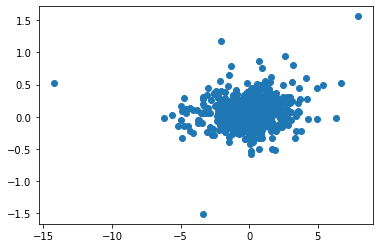

In [23]:
# produce a scatter plot of actual versus predicted data for the training set
plt.scatter(Train['spy'], Train['PredictedY'])


### Step 7: Model evaluation - statistical standards

Measure the performance of your model using the statistical metrics: 
<br>
**RMSE** and **Adjusted** $R^2$ 

In [24]:
# leave this cell unchanged but be sure to Run it.
def adjustedMetrics(data,model,model_k,yname):
    data['yhat'] = model.predict(data)
    SST = ((data[yname]-data[yname].mean())**2).sum()
    SSR = ((data['yhat']-data[yname].mean())**2).sum()
    SSE = ((data[yname]-data['yhat'])**2).sum()
    r2 = SSR/SST
    adjRsquared = 1-(1-r2)*(data.shape[0]-1)/(data.shape[0]-model_k-1)
    RMSE = (SSE/(data.shape[0]-model_k-1))**0.5
    return adjRsquared,RMSE


In [25]:
# replace ?'s with the appropriate values
print('Adjusted R-squared and RMSE for Train',adjustedMetrics(Train,lm,6,'spy'))
print('Adjusted R-squared and RMSE for Test',adjustedMetrics(Test,lm,6,'spy'))

Adjusted R-squared and RMSE for Train (0.009235689887768017, 1.5451322543611525)
Adjusted R-squared and RMSE for Test (0.01233299598184645, 3.5153656432182623)


In [26]:
# leave this cell unchanged but be sure to Run it.
def assessTable(test,train,model,model_k,yname):
    r2test,RMSEtest = adjustedMetrics(test,model,model_k,yname)
    r2train,RMSEtrain = adjustedMetrics(train,model,model_k,yname)
    assessment = pd.DataFrame(index=['R2','RMSE'],columns=['Train','Test'])
    assessment['Train'] = [r2train,RMSEtrain]
    assessment['Test'] = [r2test,RMSEtest]
    return assessment

In [27]:
# display the assessment table for your model
# replace ?'s with the appropriate values
assessTable(Test,Train,lm,6,'spy')

,Train,Test
R2,0.009236,0.012333
RMSE,1.545132,3.515366


<div align="right"><a href="#ref00">back to top</a></div>